In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import statsmodels.api as sm
import pystan

# 第1章 p.18,19

混合正規分布
$$\begin{align*}
p(x|w) &= (1-a)\mathcal{N}(x) + a\mathcal{N}(x-b) \\
\mathcal{N}(x) &= \frac1{\sqrt{2\pi}}\exp\left(-\frac{x^2}2\right) \\
W &= \left\{(a,b) \;|\; 0\leq a\leq 1, \; |b|\leq 5\right\} \\
\varphi(w) &= \frac1{10}
\end{align*}$$
真の分布
$$\begin{align*}
q(x) &= p(x|a_0, b_0) \\
(a_0, b_0) &= (0.5,3.0), \; (0.5, 1.0), \; (0.5, 0.5)
\end{align*}$$
サンプル数
$$n = 100$$

In [2]:
def gen_mixed_gaussian(a0, b0, n, seed=None):
    if seed:
        np.random.seed(seed)
    bs = np.random.choice(2, size=n, p=[1.0-a0, a0])
    return np.vectorize(
        lambda b: np.random.normal(loc=b0) if b else np.random.normal() \
        )(bs)

$n=100$のサンプルを作成する

In [3]:
np.random.seed(seed=123)
sample1 = gen_mixed_gaussian(0.5, 3.0, 100)
sample2 = gen_mixed_gaussian(0.5, 1.0, 100)
sample3 = gen_mixed_gaussian(0.5, 0.5, 100)

In [4]:
from scipy.stats import norm
xs = np.linspace(-5, 5, 101)
def mg(a0, b0, n):
    return np.vectorize( \
        lambda x: ((1-a0)*norm.pdf(x) + a0*norm.pdf(x-b0))*n
        )

プロットしてみる

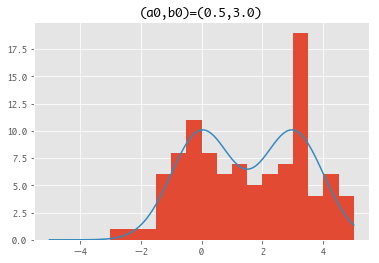

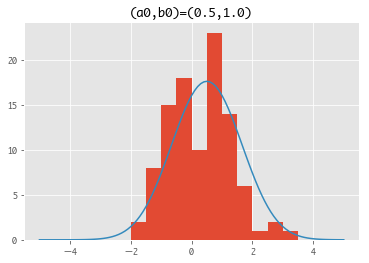

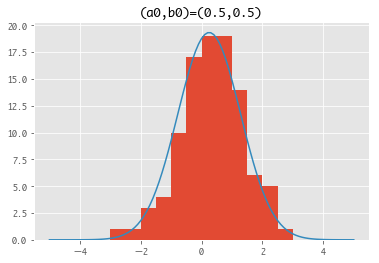

In [5]:
plt.hist(sample1, bins=20, range=(-5.0, 5.0))
plt.plot(xs, mg(0.5, 3.0, 50)(xs))
plt.title('(a0,b0)=(0.5,3.0)')
plt.show()
plt.hist(sample2, bins=20, range=(-5.0, 5.0))
plt.plot(xs, mg(0.5, 1.0, 50)(xs))
plt.title('(a0,b0)=(0.5,1.0)')
plt.show()
plt.hist(sample3, bins=20, range=(-5.0, 5.0))
plt.plot(xs, mg(0.5, 0.5, 50)(xs))
plt.title('(a0,b0)=(0.5,0.5)')
plt.show()

混合正規分布で当てはめするが、精度はでない。

In [6]:
from sklearn.mixture import GaussianMixture
gm1 = GaussianMixture(n_components=2, covariance_type='spherical')
gm1.fit([[x] for x in sample1])
print(gm1.weights_)
print(gm1.means_)
print(gm1.covariances_)

[ 0.51323679  0.48676321]
[[ 3.14557991]
 [-0.15162801]]
[ 0.76946106  0.92362133]


In [7]:
gm2 = GaussianMixture(n_components=2, covariance_type='spherical')
gm2.fit([[x] for x in sample2])
print(gm2.weights_)
print(gm2.means_)
print(gm2.covariances_)

[ 0.4115779  0.5884221]
[[-0.55853118]
 [ 0.91471121]]
[ 0.36718427  0.64473308]


In [8]:
gm3 = GaussianMixture(n_components=2, covariance_type='spherical')
gm3.fit([[x] for x in sample3])
print(gm3.weights_)
print(gm3.means_)
print(gm3.covariances_)

[ 0.45176392  0.54823608]
[[-0.25324619]
 [ 0.83559722]]
[ 0.87647464  0.69496225]


### PyStanで混合正規分布を推定してみる

In [9]:
model = """
data {
  int<lower=1> N;
  vector[N] Y;
}
parameters {
  real <lower=0, upper=1> a;
  real <lower=-5, upper=5> b;
}
model {
  for(n in 1:N) {
    target += log_sum_exp(
      log(a) + normal_lpdf(Y[n] | 0, 1),
      log1m(a) + normal_lpdf(Y[n] | b, 1)
    );
  }
}
"""

In [10]:
data1 = {'N':100, 'Y':sample1.tolist()}

In [11]:
fit1 = pystan.stan(model_code=model, data=data1, iter=1000, chains=4)
print(fit1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6bdc421632bfad283cf5b68dafff39e6 NOW.


Inference for Stan model: anon_model_6bdc421632bfad283cf5b68dafff39e6.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      0.49  1.5e-3   0.06   0.39   0.45   0.49   0.53    0.6   1463    1.0
b      3.15  4.2e-3   0.16   2.81   3.03   3.15   3.26   3.45   1509    1.0
lp__ -195.7    0.04   1.04 -198.5 -196.2 -195.4 -195.0 -194.7    859    1.0

Samples were drawn using NUTS at Thu Jun  8 18:04:35 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [12]:
data2 = {'N':100, 'Y':sample2.tolist()}
fit2 = pystan.stan(model_code=model, data=data2, iter=1000, chains=4)
print(fit2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6bdc421632bfad283cf5b68dafff39e6 NOW.


Inference for Stan model: anon_model_6bdc421632bfad283cf5b68dafff39e6.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      0.53    0.01   0.27   0.02   0.31   0.57   0.75   0.94    354   1.02
b      0.76    0.02   0.48   0.14   0.42   0.67   1.01   1.96    543   1.01
lp__ -146.4    0.07    1.3 -150.0 -146.9 -146.0 -145.4 -145.1    335    1.0

Samples were drawn using NUTS at Thu Jun  8 18:04:56 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [13]:
data3 = {'N':100, 'Y':sample3.tolist()}
fit3 = pystan.stan(model_code=model, data=data3, iter=1000, chains=4)
print(fit3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6bdc421632bfad283cf5b68dafff39e6 NOW.


Inference for Stan model: anon_model_6bdc421632bfad283cf5b68dafff39e6.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      0.44  9.5e-3   0.23   0.03   0.26   0.45   0.61   0.84    567   1.01
b      0.64    0.01   0.28   0.24   0.44   0.59   0.81   1.33    397   1.01
lp__ -146.9    0.04    1.1 -149.8 -147.3 -146.6 -146.1 -145.8    640   1.01

Samples were drawn using NUTS at Thu Jun  8 18:05:17 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### 事後分布の可視化

In [14]:
from scipy.misc import logsumexp
def lp(a,b,Y):
    lp = 0
    for y in Y:
        lp += logsumexp([np.log(1-a)-y*y/2, np.log(a)-(y-b)*(y-b)/2])
    return lp

In [15]:
from mpl_toolkits.mplot3d import Axes3D

def draw_graphs(sample):
    Z = np.array([[lp(a,b,sample) for b in np.linspace(-5, 5, 51)] for a in np.linspace(0.005, 0.995, 199)])
    fig, ax = plt.subplots()
    im = ax.pcolor(Z)
    fig.colorbar(im, ax=ax)
    plt.xlabel('b=(-5,5)')
    plt.ylabel('a=(0.005,0.995)')
    plt.show()
    
    Ze = np.exp(Z)
    fig, ax = plt.subplots()
    im = ax.pcolor(Ze)
    fig.colorbar(im, ax=ax)
    plt.xlabel('b=(-5,5)')
    plt.ylabel('a=(0.005,0.995)')
    plt.show()

    fig = plt.figure()
    ax = Axes3D(fig)
    X, Y = np.meshgrid(np.linspace(-5, 5, 51), np.linspace(0.005, 0.995, 199))
    surf=ax.plot_surface(X,Y,Ze,cmap='bwr', linewidth=0)
    fig.colorbar(surf)
    plt.show()

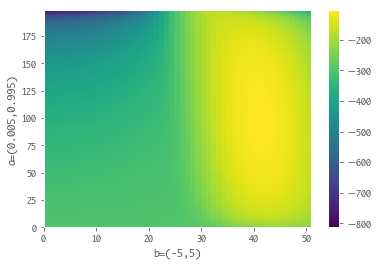

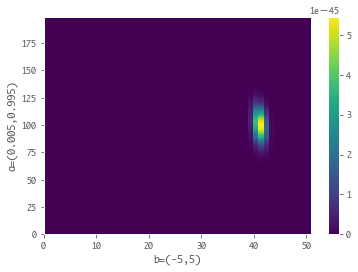

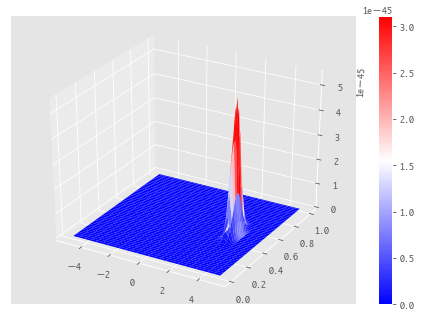

In [16]:
draw_graphs(sample1)

$$\begin{align*}
p(x|w) &= (1-a)\mathcal{N}(x) + a\mathcal{N}(x-b)
\end{align*}$$
$a \simeq 0$だと$b$の値は関係なくなる。

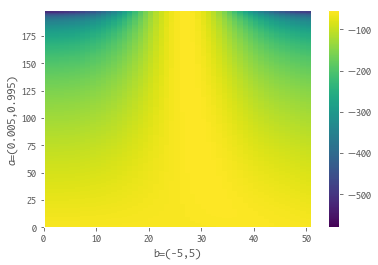

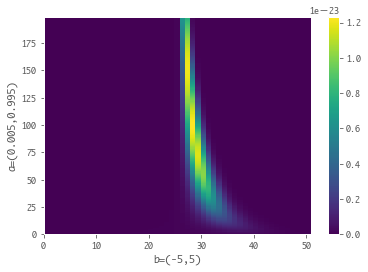

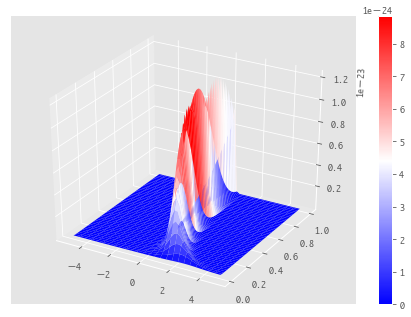

In [17]:
draw_graphs(sample2)

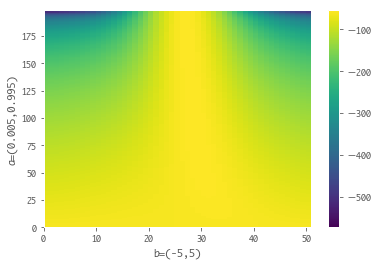

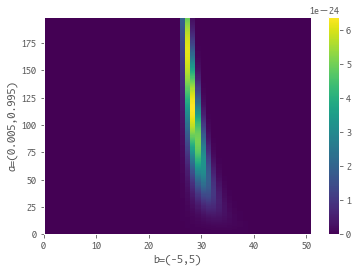

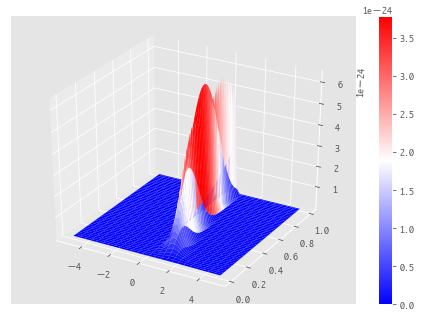

In [18]:
draw_graphs(sample3)